In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ivcurve_step_correction import get_all

In [22]:
df_raw = pd.read_csv('2024_05_16_iv.csv')

# select 1 pv module
df = df_raw[df_raw['Module Number'] == 195]
df = df.reset_index(drop=True)

In [23]:
G_key = 'Before Trace - GM5 - RefCell - Inst - Irradiance [W/m2]'
Tc_key = 'Before Trace - GM5 - RefCell - Inst - Cell Temperature [C]'

Select a reference I-V curve at high irradiance (no step)

Text(0.5, 1.0, 'Reference I-V curve (without steps)')

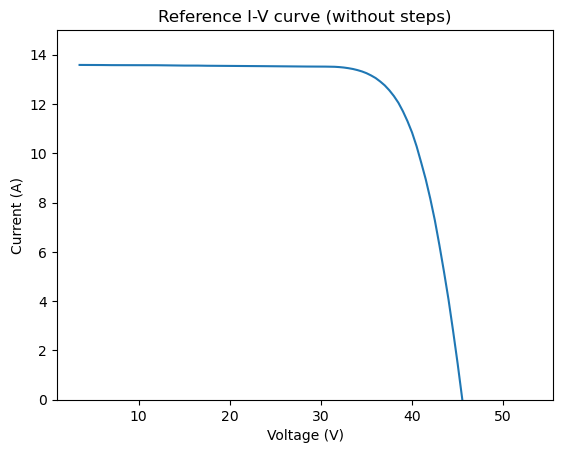

In [30]:
n = 20 # G = 999W/m2
iref = df.iloc[n,593:].to_numpy().astype(float)
vref = np.arange(0,80.5,0.5)
Gref = df[G_key][n]
Tref = df[Tc_key][n]
plt.plot(vref, iref)
plt.ylim([0,15])
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('Reference I-V curve (without steps)')

The I-V curve at low irradiance (with step) to adjust 

Text(0.5, 1.0, 'I-V curve to correct (with steps)')

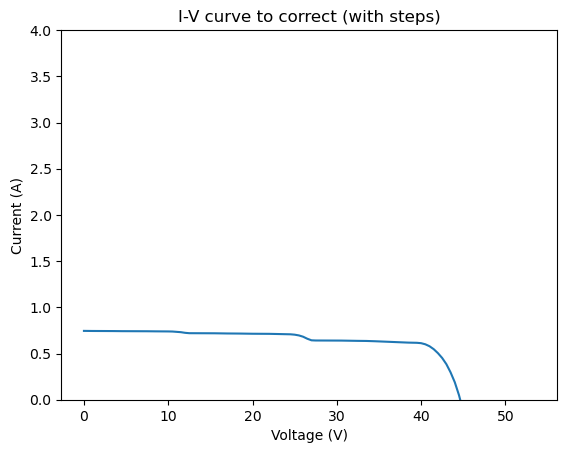

In [31]:
n = 12 # G = 41.9W/m2
i = df.iloc[n,593:].to_numpy().astype(float)
v = np.arange(0,80.5,0.5)
G = df[G_key][n]
T = df[Tc_key][n]
plt.plot(v, i)
plt.ylim([0,4])
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('I-V curve to correct (with steps)')

Adjust measured I-V curve

In [26]:
# get coefficients
alpha, beta, k = get_all(v, i, vref, iref, Gref, G, Tref, T)

# correct i-v curve
i_corr = iref*G/Gref/(1 + alpha*(T-Tref))
v_corr = vref - k*i_corr*(T-Tref) + beta*(T-Tref)

# interpolate corrected i-v curve
vi = v
inx = (~np.isnan(v_corr)) & (~np.isnan(i_corr))
ii = np.interp(vi, v_corr[inx], i_corr[inx])

Plot and compare adjusted and measured I-V curves

Text(0, 0.5, 'Current (A)')

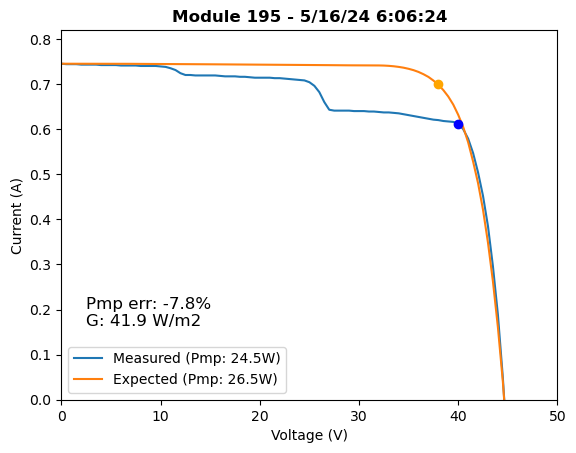

In [27]:
n = 12
i = df.iloc[n,593:].to_numpy().astype(float)
v = np.arange(0,80.5,0.5)
G = df[G_key][n]
T = df[Tc_key][n]

idpmp_c = np.nanargmax(v_corr*i_corr)
pmp_c = np.nanmax(v_corr*i_corr)
idpmp = np.nanargmax(v*i)
pmp = np.nanmax(v*i)
pmperr = (pmp-pmp_c)/pmp_c*100

plt.plot(v, i, label = f'Measured (Pmp: {pmp:.1f}W)')
plt.plot(vi, ii, label = f'Expected (Pmp: {pmp_c:.1f}W)')
plt.plot(v[idpmp], i[idpmp], 'o', color = 'blue')
plt.plot(v_corr[idpmp_c], i_corr[idpmp_c], 'o', color = 'orange')
plt.ylim([0,np.nanmax(i)*1.1])
plt.xlim([0,50])
plt.text(0.05, 0.2, f"Pmp err: {pmperr:.1f}%\nG: {df[G_key][n]:.1f} W/m2", transform=plt.gca().transAxes,
         fontsize = 12)
plt.legend()
plt.title(f"Module 195 - {df['Datetime'][n]}", fontweight = 'bold')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')

